In [1]:
import pandas as pd
import numpy as np
import os
import cv2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls /Users/yoavfreund/projects/cell_detection_data/sections/

172.tgz CH1     CH3


In [3]:
animal = 'DK55'
section = 172
INPUT3 = '/Users/yoavfreund/projects/cell_detection_data/sections/CH3/172'
!ls $INPUT3

172tile-0.tif                    172tile-6.tif
172tile-1.tif                    172tile-7.tif
172tile-2.tif                    172tile-8.tif
172tile-3.tif                    172tile-9.tif
172tile-4.tif                    DK55_premotor_172_2021-10-18.csv
172tile-5.tif


In [4]:
INPUT1 = '/Users/yoavfreund/projects/cell_detection_data/sections/CH1/172'
!ls $INPUT1

172tile-0.tif 172tile-2.tif 172tile-4.tif 172tile-6.tif 172tile-8.tif
172tile-1.tif 172tile-3.tif 172tile-5.tif 172tile-7.tif 172tile-9.tif


In [5]:
### Tiles info
# the original images are width=60000, height=34000.
#### Tile organzation
# 5 rows (height/5), 2 columns (width/2)

width = 60000
height = 34000
tile_height = int(height / 5)
tile_width=int(width/2)
print('width=%d, tile_width=%d ,height=%d, tile_height=%d'%(width, tile_width,height,tile_height))
origins={}
for i in range(10):
    row=int(i/2)
    col=i%2
    origins[i] = (row*tile_height,col*tile_width)
print('origins=',origins)

width=60000, tile_width=30000 ,height=34000, tile_height=6800
origins= {0: (0, 0), 1: (0, 30000), 2: (6800, 0), 3: (6800, 30000), 4: (13600, 0), 5: (13600, 30000), 6: (20400, 0), 7: (20400, 30000), 8: (27200, 0), 9: (27200, 30000)}


In [6]:
%%time
tile=5
file = '%dtile-%d.tif'%(section,tile)
radius = 400
color = (2000)
infile = os.path.join(INPUT3, file)
img3 = cv2.imread(infile, -1)
img3.shape

CPU times: user 1.98 s, sys: 586 ms, total: 2.56 s
Wall time: 3.1 s


(6800, 30000)

In [7]:
infile = os.path.join(INPUT1, file)
img1 = cv2.imread(infile, -1)
img1.shape

(6800, 30000)

In [8]:
# for using tile = 5, we push the origin down 2 tile_heights

dfpath = os.path.join(INPUT3, 'DK55_premotor_172_2021-10-18.csv')
df = pd.read_csv(dfpath)
df.shape

(115, 3)

In [9]:
in_row_min=5400; in_row_max=6800; in_col_min=8000; in_col_max=13000
#in_row_min=0; in_row_max=6800; in_col_min=0; in_col_max=30000
vimg3=img3[in_row_min:in_row_max, in_col_min: in_col_max]
vimg1=img1[in_row_min:in_row_max, in_col_min: in_col_max]

In [10]:
def show_image(img,_title="",fsize=[15,15]):
    plt.figure(figsize=[15,15])
    plt.imshow(img, cmap="gray")
    plt.title(_title,fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()

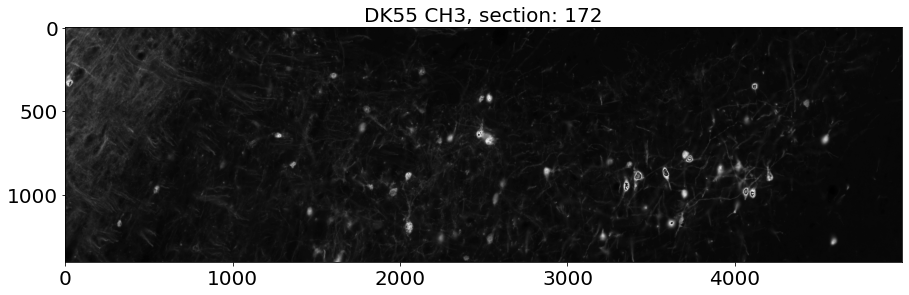

In [11]:
show_image(4*vimg3,_title=f'{animal} CH3, section: {section}')

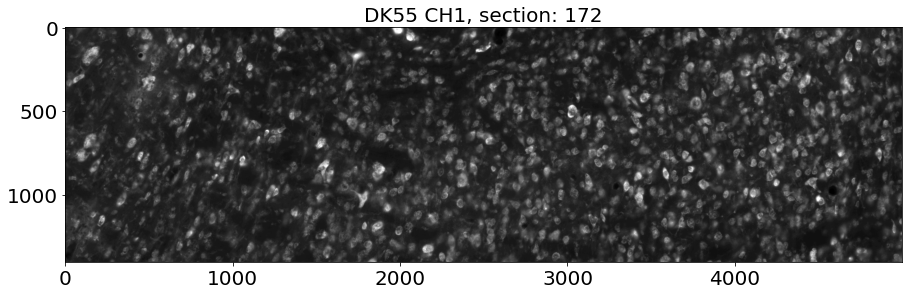

In [12]:
show_image(vimg1,_title=f'{animal} CH1, section: {section}')

In [13]:
def collect_positives(uimg1,uimg3,radius = 80):
    img1=np.copy(uimg1)
    img3=np.copy(uimg3)
    positives=[]
    a=int(radius/2)
    color = (6000)
    min_row,min_col = origins[tile]
    for index,r in df.iterrows():
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img3=cv2.circle(img3, (int(col), int(row)), radius, color, 2)
        I1=uimg1[row-a:row+a,col-a:col+a]
        I3=uimg3[row-a:row+a,col-a:col+a]
        if I1.shape==(radius,radius):
            positives.append((col,row,I1,I3))

    return img3,positives

In [14]:
radius=80
annotated_img,positives=collect_positives(img1,img3,radius=radius)

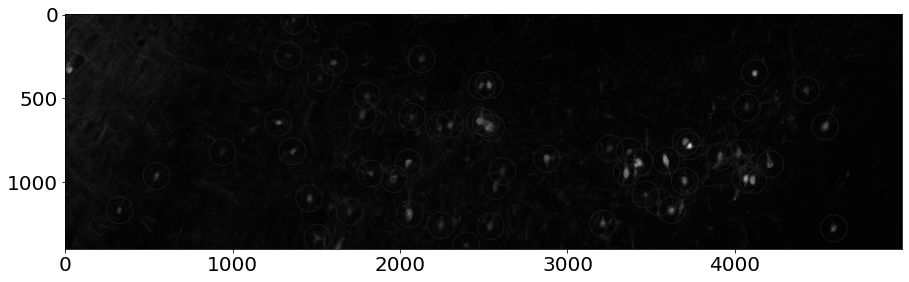

In [15]:
vimg=annotated_img[in_row_min:in_row_max, in_col_min: in_col_max]
show_image(vimg)


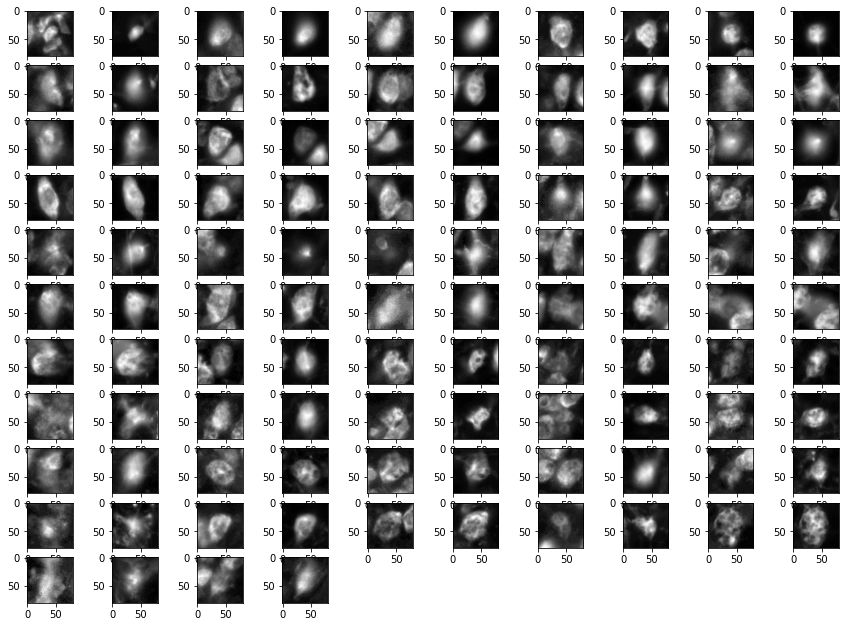

In [17]:
plt.figure(figsize=[15,30])
for i in range(len(positives)):
    plt.subplot(30,10,2*i+1)
    plt.imshow(positives[i][2], cmap="gray")
    plt.subplot(30,10,2*i+2)
    plt.imshow(positives[i][3], cmap="gray")
    if i>50:
        break
plt.show()

In [12]:
def plot_dist(uimg):
    H=uimg.flatten()
    H=np.sort(H)

    H=H[0:-1:1000]
    plt.figure()
    plt.plot(H,np.arange(0,1,1./H.shape[0]))
    plt.grid()
    plt.figure()
    plt.hist(H,bins=100);

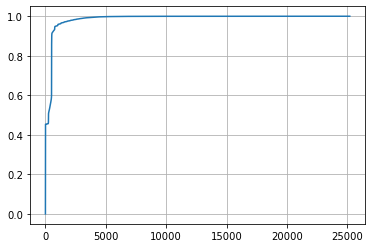

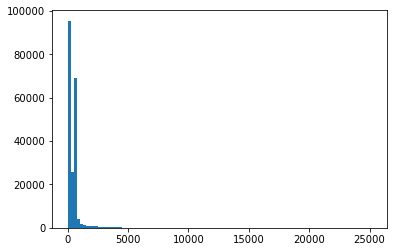

In [13]:
plot_dist(img)

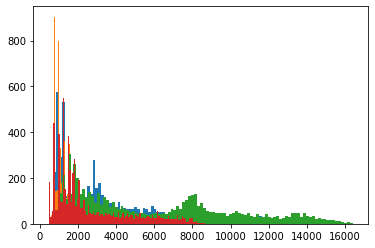

In [14]:
for i in [10,20,30,40]:
    plt.hist(positives[i][2].flatten(),bins=100);

In [15]:
##Check that all images are of the same sie 
for i in range(len(positives)):
    _shape=positives[i][2].shape
    if _shape !=(80,80):
        print(i,_shape)

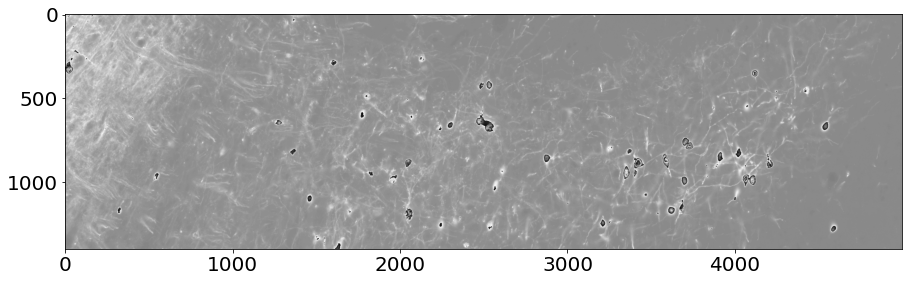

In [16]:
img=np.int16(img)
show_image(5*img[in_row_min:in_row_max, in_col_min: in_col_max]);

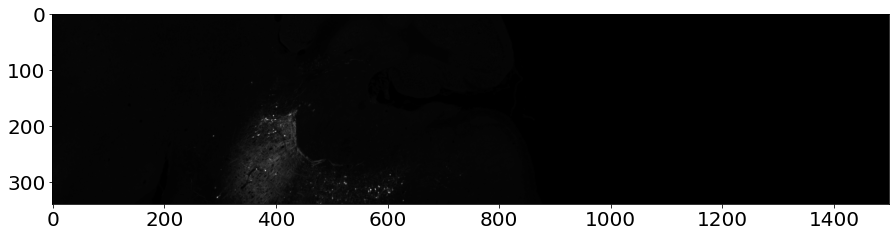

In [17]:
small=cv2.resize(img,(0,0),fx=0.05,fy=0.05, interpolation=cv2.INTER_AREA)
show_image(small);

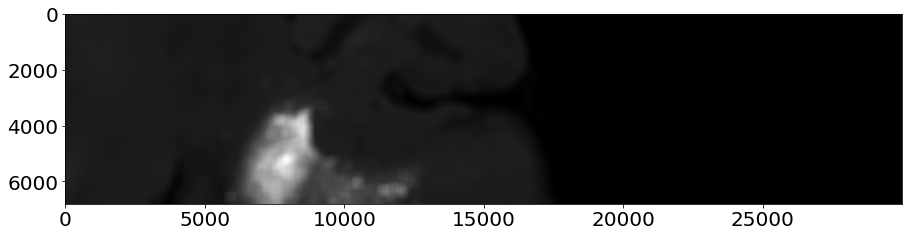

In [18]:
blur=cv2.GaussianBlur(small,ksize=(21,21),sigmaX=10)
relarge=cv2.resize(blur,(0,0),fx=20,fy=20) #,interpolation=cv2.INTER_AREA)
show_image(relarge);

In [19]:
img.shape,small.shape,relarge.shape,type(img[0,0]),type(relarge[0,0])

((6800, 30000), (340, 1500), (6800, 30000), numpy.int16, numpy.int16)

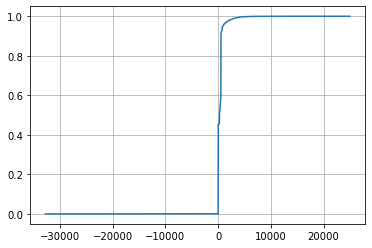

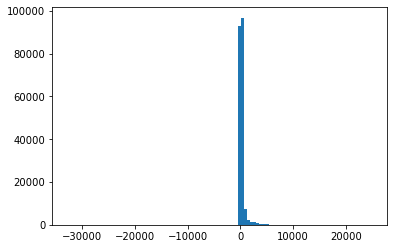

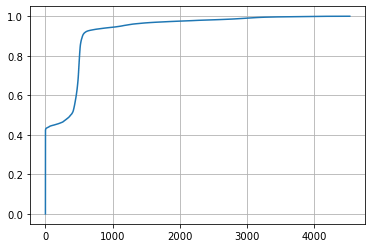

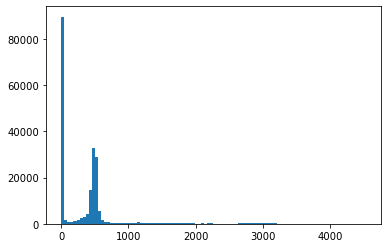

In [20]:
plot_dist(img)
plot_dist(relarge)

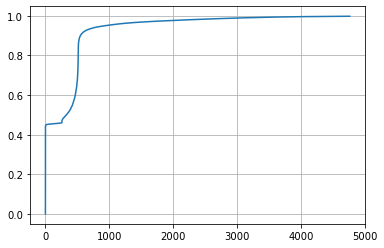

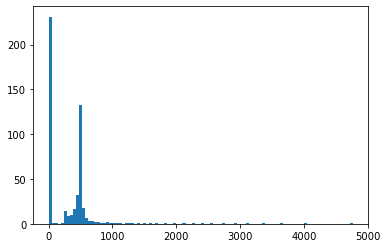

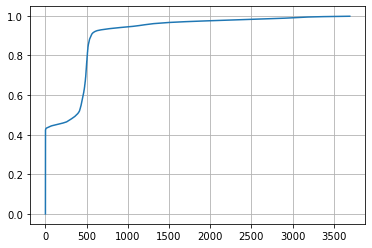

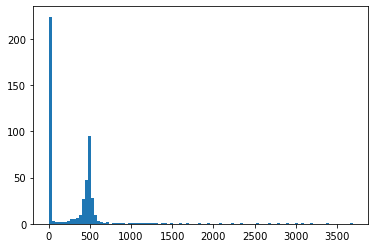

In [21]:
plot_dist(small)
plot_dist(blur)

In [22]:
np.mean(img.flatten()),np.mean(relarge.flatten()),np.std(img.flatten()),np.std(relarge.flatten())

(350.9208851960784, 350.9592194117647, 613.9972973798497, 515.1333680087905)

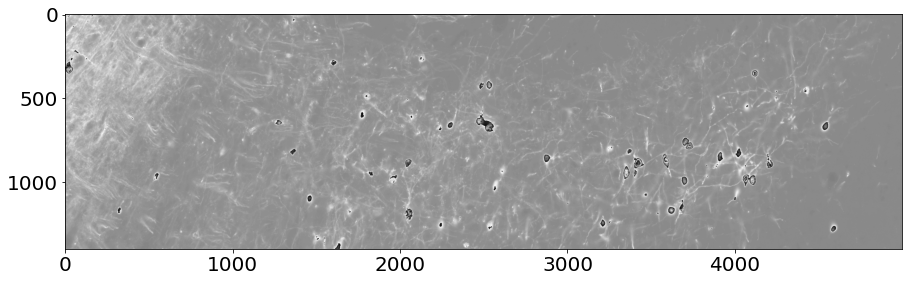

In [23]:
vimg=img[in_row_min:in_row_max, in_col_min: in_col_max]
show_image(5*vimg)

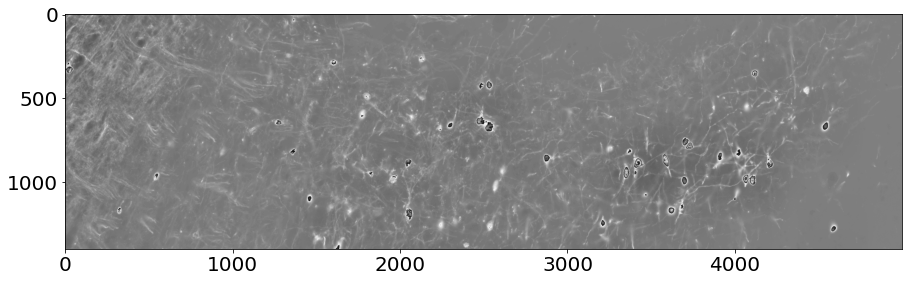

In [24]:
diff=img-relarge
show_image(5*diff[in_row_min:in_row_max, in_col_min: in_col_max]);

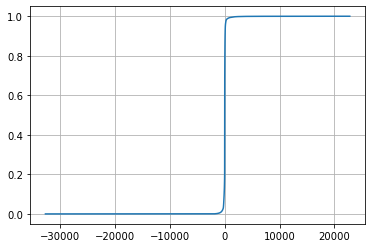

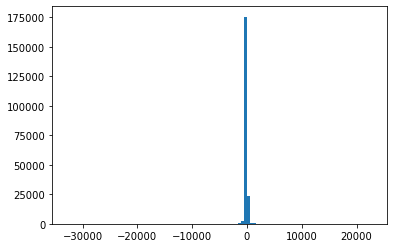

In [25]:
plot_dist(diff)

<Figure size 1080x1080 with 0 Axes>

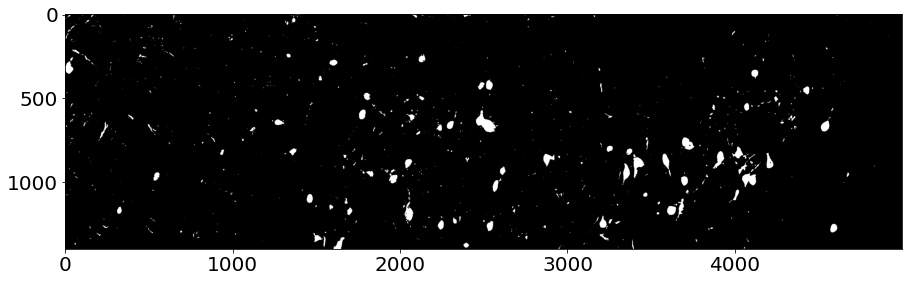

In [26]:
thresh=2000
plt.figure(figsize=[15,15])
vdiff=diff[in_row_min:in_row_max, in_col_min: in_col_max]
show_image(vdiff>thresh);

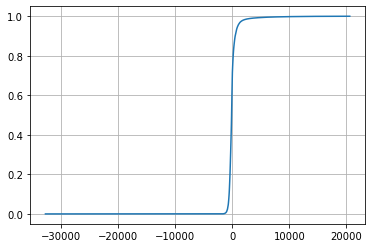

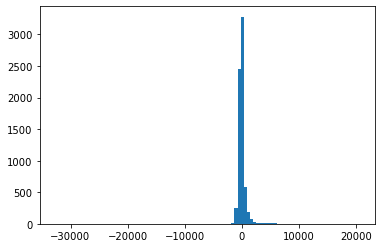

In [27]:
plot_dist(diff[in_row_min:in_row_max, in_col_min: in_col_max])

In [28]:
Stats=cv2.connectedComponentsWithStats(np.int8(diff>thresh))
Stats[0]

4795

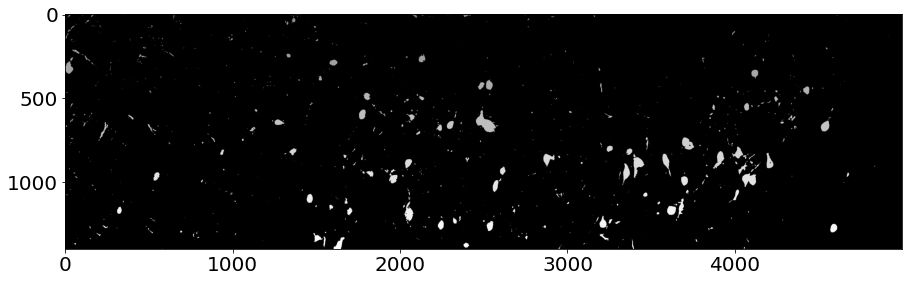

In [29]:
show_image(Stats[1][in_row_min:in_row_max, in_col_min: in_col_max])

In [30]:
Stats[2].shape, Stats[3].shape

((4795, 5), (4795, 2))

In [31]:
origin= np.array(origins[tile],dtype=np.int16)
origin,tile_height,tile_width

(array([13600, 30000], dtype=int16), 6800, 30000)

In [32]:
candid_coor=np.int32(Stats[3])
candid_coor=candid_coor[:,1::-1]
np.max(candid_coor,axis=0),candid_coor.shape

(array([ 6799, 15013], dtype=int32), (4795, 2))

In [33]:
pos_coor=np.int32(df[['y','x']])-origin
pos_coor.shape,np.max(pos_coor,axis=0)

((115, 2), array([ 9573, 14627], dtype=int32))

In [34]:
L_pos_coor=[]
for i in range(pos_coor.shape[0]):
    row,col=list(pos_coor[i,:])
    if row<0 or row>=tile_height or col<0 or col>=tile_width:
        continue
    L_pos_coor.append(np.array([row,col]))
pos_coor_tile=np.stack(L_pos_coor)
pos_coor_tile.shape,pos_coor.shape

((90, 2), (115, 2))

In [35]:
np.max(pos_coor_tile,axis=0),np.min(pos_coor_tile,axis=0)

(array([ 6778, 14627], dtype=int32), array([2452, 5793], dtype=int32))

In [36]:
np.max(candid_coor,axis=0),np.min(candid_coor,axis=0),

(array([ 6799, 15013], dtype=int32), array([ 131, 2585], dtype=int32))

In [37]:
Stats[2].shape
labels=np.zeros(Stats[2].shape[0])
labels.shape

(4795,)

In [52]:
def print_info(x):
    print(type(x))
    if type(x)==np.ndarray:
        print(x.shape)
        print(type(x[0,0]))
print_info(pos_coor_tile)
print_info(candid_coor)

<class 'numpy.ndarray'>
(90, 2)
<class 'numpy.int32'>
<class 'numpy.ndarray'>
(4795, 2)
<class 'numpy.int32'>


In [48]:
from numpy.linalg import norm
Dists=[]
for i in range(len(pos_coor_tile)):
    c=norm(candid_coor-pos_coor_tile[i],axis=1)
    #if(np.min(c)>50):
    row,col=pos_coor_tile[i]
    index1=np.argmin(c)
    index2=Stats[1][row,col]
    if index1==index2:
        print(candid_coor[index1,:],pos_coor_tile[i],np.min(c))
        labels[index1]=1
    if index1 !=index2 :
        Dists.append((i,np.min(c),index2,index1))
Dists, sum(labels)

[ 5769 14627] [ 5771 14627] 2.0
[ 6675 12591] [ 6676 12592] 1.4142135623730951
[ 6068 12541] [ 6070 12540] 2.23606797749979
[ 5853 12429] [ 5851 12428] 2.23606797749979
[ 5753 12120] [ 5750 12119] 3.1622776601683795
[ 5952 12071] [ 5955 12073] 3.605551275463989
[ 6281 12207] [ 6294 12212] 13.92838827718412
[ 6384 12087] [ 6389 12111] 24.515301344262525
[ 6384 12087] [ 6381 12064] 23.194827009486403
[ 6228 12021] [ 6228 12023] 2.0
[ 6265 11909] [ 6250 11914] 15.811388300841896
[ 6173 11717] [ 6163 11707] 14.142135623730951
[ 6173 11717] [ 6187 11731] 19.79898987322333
[ 6392 11700] [ 6395 11701] 3.1622776601683795
[ 6569 11622] [ 6567 11625] 3.605551275463989
[ 6280 11591] [ 6272 11592] 8.06225774829855
[ 6298 11419] [ 6283 11428] 17.4928556845359
[ 6343 11351] [ 6340 11354] 4.242640687119285
[ 6645 11213] [ 6649 11212] 4.123105625617661
[ 6219 11370] [ 6217 11371] 2.23606797749979
[ 6201 11253] [ 6201 11253] 0.0
[ 6476 11466] [ 6474 11466] 2.0
[ 6525 11546] [ 6521 11548] 4.472135954999

([(31, 35.35533905932738, 3569, 3704),
  (66, 29.0, 986, 1028),
  (68, 39.824615503479755, 986, 959),
  (80, 33.60059523282288, 870, 908),
  (81, 29.154759474226502, 870, 865),
  (86, 18.601075237738275, 394, 389),
  (87, 34.17601498127012, 187, 235)],
 79.0)

In [39]:
def collect_examples(uimg,radius = 80):
    img=np.copy(uimg)
    positives=[]
    a=int(radius/2)
    color = (6000)
    min_row,min_col = origins[tile]
    for index,r in df.iterrows():
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img=cv2.circle(img, (int(col), int(row)), radius, color, 2)
        I=uimg[row-a:row+a,col-a:col+a]
        if I.shape==(radius,radius):
            positives.append((col,row,I))

    return img,positives

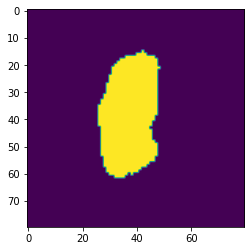

In [40]:
im=positives[10][2]
im=np.uint8(im>8000)
imshow(im)

In [41]:
# Calculate Moments
moments = cv2.moments(im)
# Calculate Hu Moments
huMoments = cv2.HuMoments(moments)

huMoments, moments

In [43]:
min_size=int(80/2)
Examples=[]
for j in range(len(labels)):
    col_min,row_min,width,height,area = Stats[2][j,:]
    width2=int(width/2)
    height2=int(height/2)
    col_center=col_min+width2
    row_center=row_min+height2
    height2*=2; height2=max(height2,min_size)
    width2*=2; width2=max(width2,min_size)
    example={'index':j,
             'label':labels[j],
             'area':area,
             'image':img[row_center-height2:row_center+height2,col_center-width2:col_center+width2]
            }
    Examples.append(example)
len(Examples)

4795

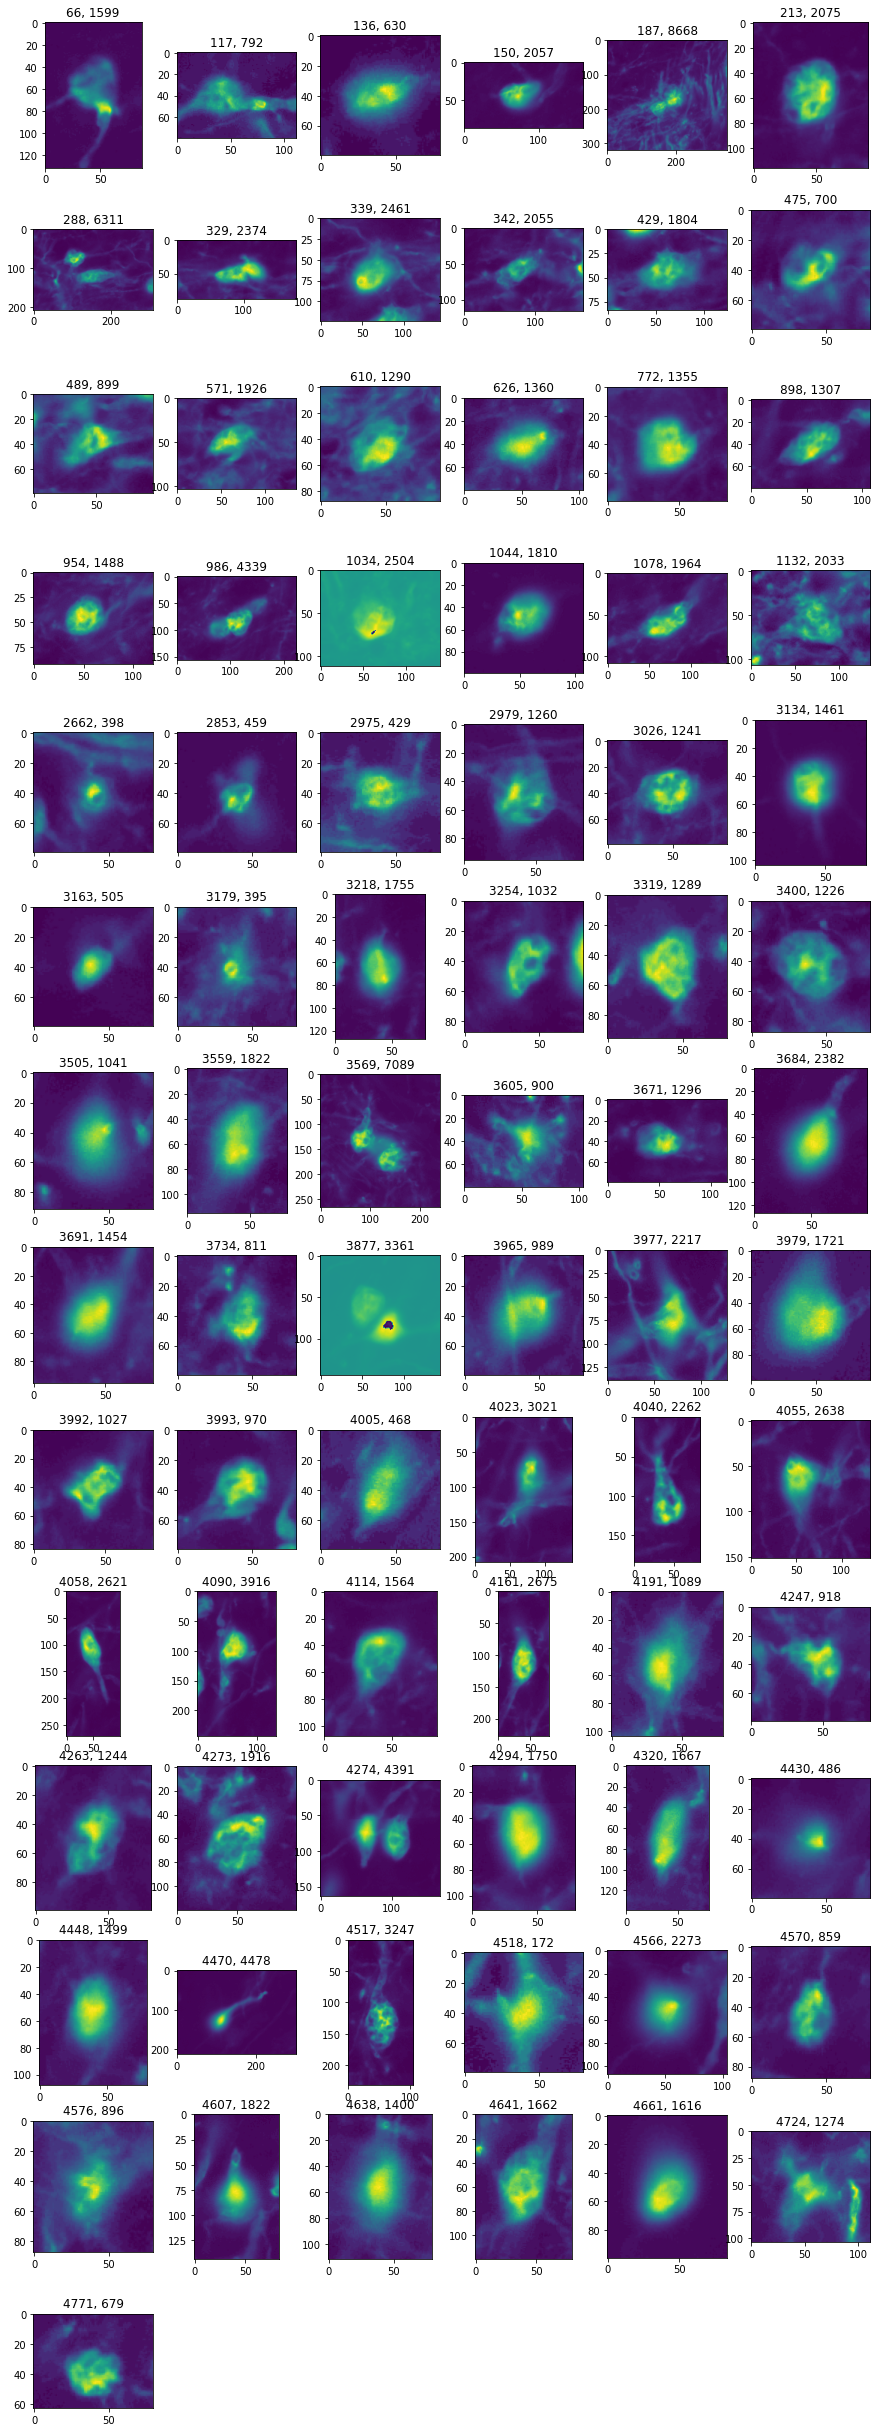

In [44]:
figure(figsize=[15,70])
i=1
for j in range(len(Examples)):
    example=Examples[j]
    if example['label']==0:
        continue
    subplot(22,6,i)
    i+=1
    imshow(example['image'])
    title('%d, %d'%(j,example['area']))


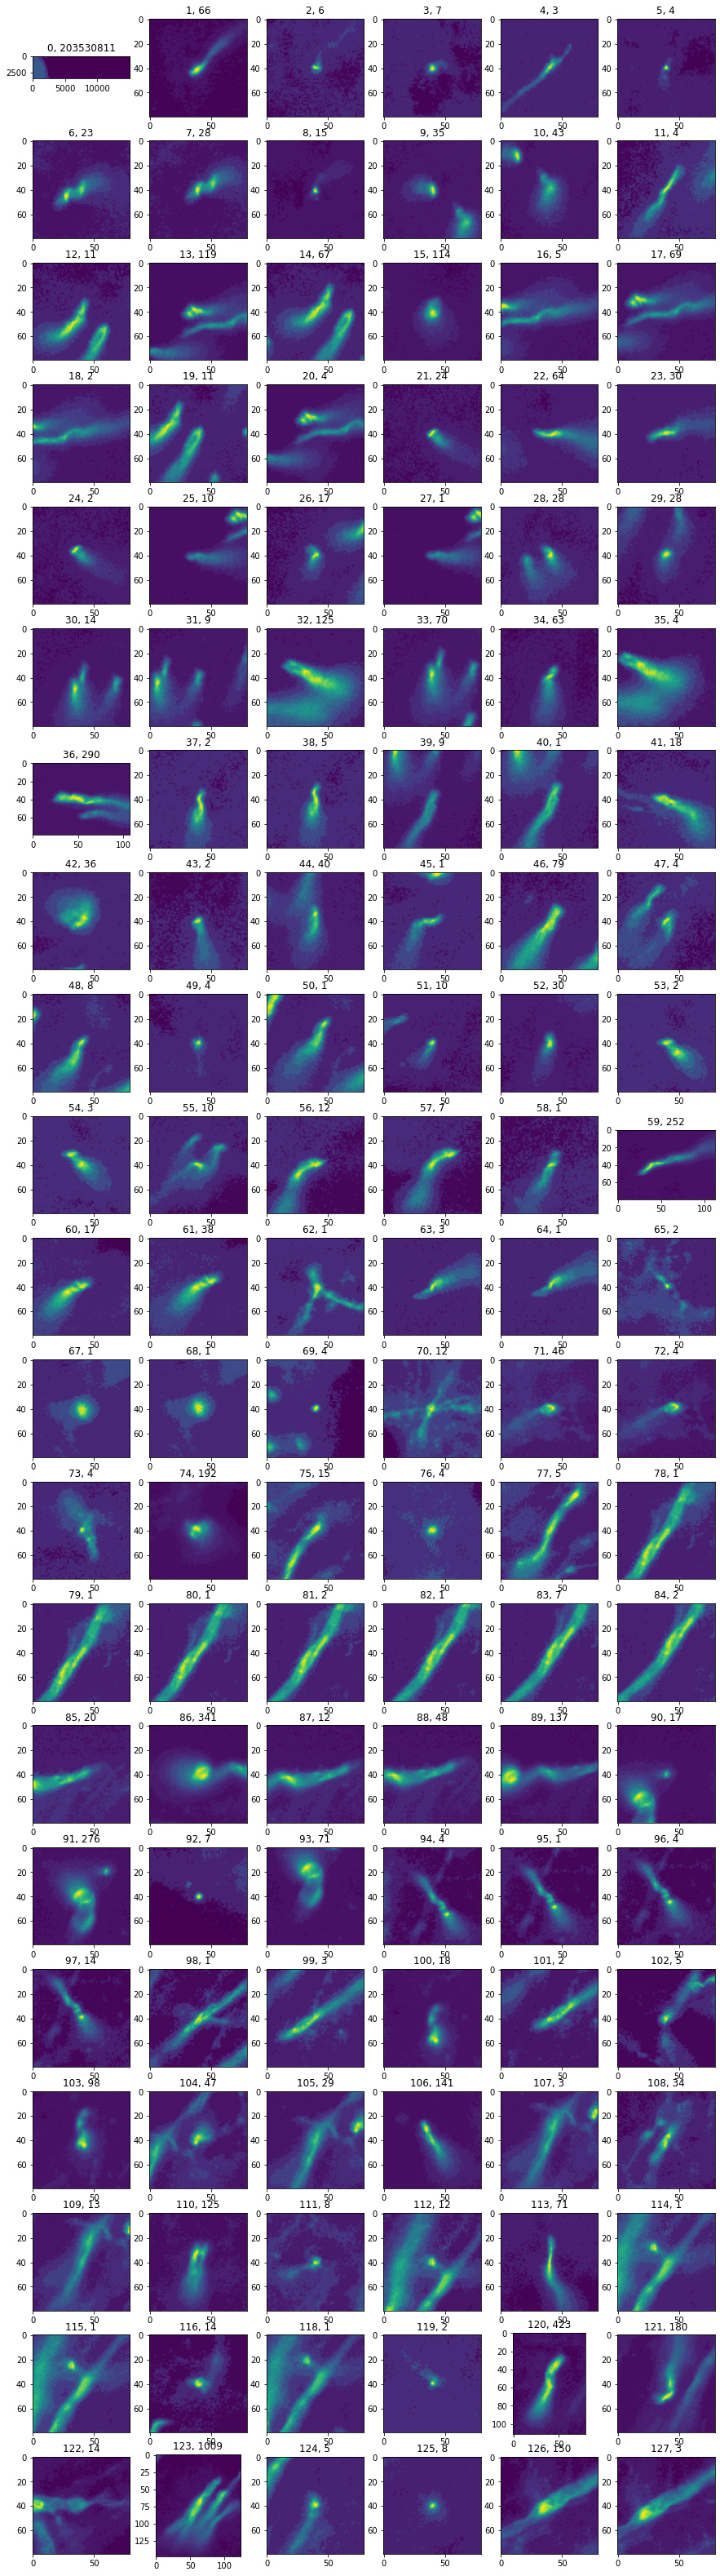

In [45]:
figure(figsize=[15,60])
i=1
for j in range(len(Examples)):
    example=Examples[j]
    if example['label']==1:
        continue
    subplot(22,6,i)
    i+=1
    imshow(example['image'])
    title('%d, %d'%(j,example['area']))
    if i>21*6:
        break



In [46]:
import pickle as pkl
with open('examples.pkl','bw') as pkl_file:
    pkl.dump(Examples,pkl_file)
!ls -lh *.pkl

-rw-r--r--  1 yoavfreund  staff   162M Aug  9 17:14 examples.pkl
-rw-r--r--  1 yoavfreund  staff    50K Aug  3 14:08 mean.pkl
